# Analysis of intervention measures

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from os.path import join
from os import listdir
import numpy as np
import seaborn as sns

## Intervention measures

In [32]:
src = '../data/simulation_results/ensembles_intervention_measures'

results = pd.DataFrame()
for f in listdir(src):
    tmp = pd.read_csv(join(src, f))
    results = pd.concat([results, tmp])
    
results = results.reset_index(drop=True)
# subtract the index case
results['infected_agents'] = results['infected_agents'] - 1
results['occupancy'] = results['presence_fraction'] * 100
results['occupancy'] = results['occupancy'].astype(int)
results['occupancy'] = results['occupancy'].apply(lambda x: '{}%'.format(x))
results = results.set_index(['unistudent_mask', 'lecturer_mask', 'presence_fraction'])

In [33]:
print('{:1.1f}% of index cases to not lead to an outbreak'\
      .format(len(results[results['infected_agents'] == 0]) / len(results) * 100))

91.8% of index cases to not lead to an outbreak


In [34]:
results['scenario'] = np.nan
results.loc[(0, 0, slice(None)), 'scenario'] = 'no masks'
results.loc[(1, 1, slice(None)), 'scenario'] = 'universal masks'
results.loc[(1, 0, slice(None)), 'scenario'] = 'masks students'
results.loc[(0, 1, slice(None)), 'scenario'] = 'masks faculty'
results = results.reset_index()

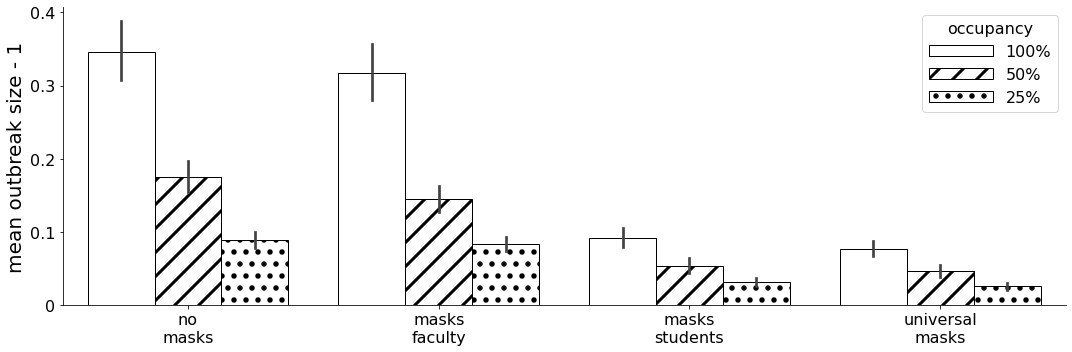

In [41]:
green = '#229954'
blue = '#2471A3'
grey = '#7F8C8D'

plt.rcParams['hatch.linewidth'] = 3
order = ['no masks', 'masks faculty', 'masks students', 'universal masks']
hue_order = ['100%', '50%', '25%']
vacc_ratio = 0.8
subset = results[results['unistudent_vaccination_ratio'] == vacc_ratio]
g = sns.catplot(x='scenario', y='infected_agents',
                hue='occupancy', data=subset, kind="bar", aspect=3,
                order=order, legend=False, palette=['w', 'w', 'w'],
                row='unistudent_vaccination_ratio', hue_order=hue_order)

ax = g.axes[0][0]
#ax.set_title('vaccination coverage {:1.0f}%'.format(vacc_ratio * 100), fontsize=24)
ax.set_title('')
ax.set_ylabel('mean outbreak size - 1', fontsize=20)
ax.set_xlabel('')
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4], fontsize=16)
ax.set_xticklabels(['no\nmasks', 'masks\nfaculty', 
                    'masks\nstudents', 'universal\nmasks'], fontsize=16)

for i in [0, 1, 2, 3]:
    bar = ax.patches[i]
    #hatch = '.'
    #bar.set_hatch(hatch)
    bar.set_edgecolor('k')

for i in [4, 5, 6, 7]:
    bar = ax.patches[i]
    hatch = '/'
    bar.set_hatch(hatch)
    bar.set_edgecolor('k')
    
for i in [8, 9, 10, 11]:
    bar = ax.patches[i]
    hatch = '.'
    bar.set_hatch(hatch)
    bar.set_edgecolor('k')

patch1 = mpatches.Patch(facecolor='w', label='100%', edgecolor='k')
patch2 = mpatches.Patch(facecolor='w', hatch='/', label='50%', edgecolor='k')
patch3 = mpatches.Patch(facecolor='w', hatch='.', label='25%', edgecolor='k')

legend = ax.legend(handles = [patch1, patch2, patch3], loc=1, fontsize=16, 
          title='occupancy', handlelength=4)
plt.setp(legend.get_title(),fontsize=16)
plt.tight_layout()
plt.savefig('../plots/outbreak_size.png', dpi=300)
plt.savefig('../plots/outbreak_size.pdf')
plt.savefig('../plots/outbreak_size.svg')

In [44]:
results = results.set_index(['unistudent_mask', 'lecturer_mask', 
                             'presence_fraction', 'unistudent_vaccination_ratio'])

### 80% vaccination coverage

#### 100% occupancy

In [56]:
results.loc[0, 0, 1, 0.8]['R0'].mean()

<ipython-input-56-9b738dc11118>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.8]['R0'].mean()


0.1924

In [57]:
results.loc[0, 0, 1, 0.8]['R0'].quantile(0.025)

<ipython-input-57-0a33d1341c4e>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.8]['R0'].quantile(0.025)


0.0

In [58]:
results.loc[0, 0, 1, 0.8]['R0'].quantile(0.975)

<ipython-input-58-e8cc3c59df47>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.8]['R0'].quantile(0.975)


2.0

In [45]:
results.loc[0, 0, 1, 0.8]['infected_agents'].mean()

<ipython-input-45-542f45b1c0f0>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.8]['infected_agents'].mean()


0.3452

In [50]:
results.loc[0, 0, 1, 0.8]['infected_agents'].quantile(0.025)

<ipython-input-50-144054a9ef58>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.8]['infected_agents'].quantile(0.025)


0.0

In [46]:
results.loc[0, 0, 1, 0.8]['infected_agents'].quantile(0.90)

<ipython-input-46-e1852cf0eaa0>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.8]['infected_agents'].quantile(0.90)


1.0

In [49]:
results.loc[0, 0, 1, 0.8]['infected_agents'].quantile(0.975)

<ipython-input-49-ad5d2611794f>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.8]['infected_agents'].quantile(0.975)


3.0

In [47]:
results.loc[0, 0, 1, 0.8]['infected_agents'].quantile(0.99)

<ipython-input-47-9a49b9936fb5>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.8]['infected_agents'].quantile(0.99)


6.0

In [48]:
results.loc[0, 0, 1, 0.8]['infected_agents'].max()

<ipython-input-48-35c28ba601dc>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.8]['infected_agents'].max()


36.0

#### 100% occupancy & masks

In [51]:
results.loc[1, 1, 1, 0.8]['infected_agents'].mean()

<ipython-input-51-e4b011ee39ea>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[1, 1, 1, 0.8]['infected_agents'].mean()


0.077

In [54]:
results.loc[1, 1, 1, 0.8]['infected_agents'].quantile(0.025)

<ipython-input-54-2b25276c5a2f>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[1, 1, 1, 0.8]['infected_agents'].quantile(0.025)


0.0

In [55]:
results.loc[1, 1, 1, 0.8]['infected_agents'].quantile(0.975)

<ipython-input-55-2dd9d5e0d9bc>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[1, 1, 1, 0.8]['infected_agents'].quantile(0.975)


1.0

In [52]:
results.loc[1, 1, 1, 0.8]['infected_agents'].quantile(0.99)

<ipython-input-52-62769f1ec8df>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[1, 1, 1, 0.8]['infected_agents'].quantile(0.99)


2.0

In [53]:
results.loc[1, 1, 1, 0.8]['infected_agents'].max()

<ipython-input-53-d6072645daea>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[1, 1, 1, 0.8]['infected_agents'].max()


5.0

### 70% vaccination coverage

#### 100% occupancy

In [59]:
results.loc[0, 0, 1, 0.7]['R0'].mean()

<ipython-input-59-fc2f04385da3>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.7]['R0'].mean()


0.2694

In [60]:
results.loc[0, 0, 1, 0.7]['R0'].quantile(0.025)

<ipython-input-60-d45fd551e6d4>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.7]['R0'].quantile(0.025)


0.0

In [61]:
results.loc[0, 0, 1, 0.7]['R0'].quantile(0.975)

<ipython-input-61-24b11046c7c6>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.7]['R0'].quantile(0.975)


2.0

In [62]:
results.loc[0, 0, 1, 0.7]['infected_agents'].mean()

<ipython-input-62-fc334ae367d6>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.7]['infected_agents'].mean()


0.791

In [63]:
results.loc[0, 0, 1, 0.7]['infected_agents'].quantile(0.025)

<ipython-input-63-d1ed4293bcc0>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.7]['infected_agents'].quantile(0.025)


0.0

In [64]:
results.loc[0, 0, 1, 0.7]['infected_agents'].quantile(0.90)

<ipython-input-64-cc7c114fb07c>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.7]['infected_agents'].quantile(0.90)


1.0

In [65]:
results.loc[0, 0, 1, 0.7]['infected_agents'].quantile(0.975)

<ipython-input-65-3d8b63aa9cdc>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.7]['infected_agents'].quantile(0.975)


6.0

In [66]:
results.loc[0, 0, 1, 0.7]['infected_agents'].quantile(0.99)

<ipython-input-66-93af57092e45>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.7]['infected_agents'].quantile(0.99)


15.0

In [70]:
results.loc[0, 0, 1, 0.7]['infected_agents'].quantile(0.9998)

<ipython-input-70-b3f1a378c2f2>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.7]['infected_agents'].quantile(0.9998)


100.00640000001295

In [67]:
results.loc[0, 0, 1, 0.7]['infected_agents'].max()

<ipython-input-67-ee6859c01e9b>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc[0, 0, 1, 0.7]['infected_agents'].max()


132.0

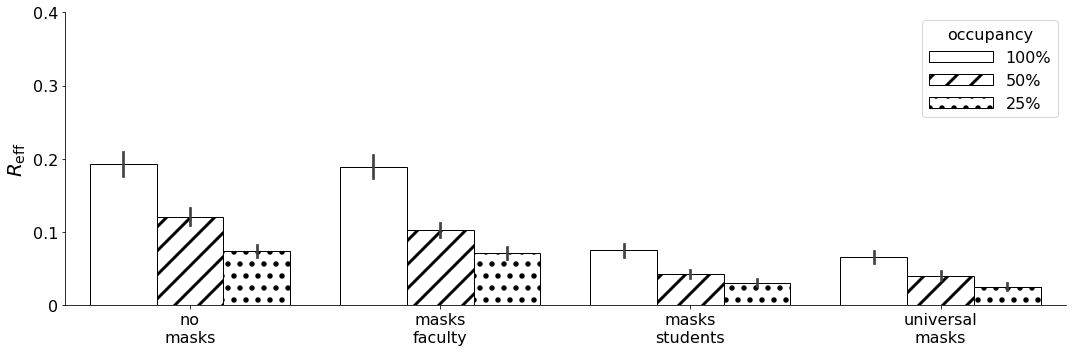

In [40]:
green = '#229954'
blue = '#2471A3'
grey = '#7F8C8D'

plt.rcParams['hatch.linewidth'] = 3
order = ['no masks', 'masks faculty', 'masks students', 'universal masks']
hue_order = ['100%', '50%', '25%']
vacc_ratio = 0.8
subset = results[results['unistudent_vaccination_ratio'] == vacc_ratio]
g = sns.catplot(x='scenario', y='R0',
                hue='occupancy', data=subset, kind="bar", aspect=3,
                order=order, legend=False, palette=['w', 'w', 'w'],
                row='unistudent_vaccination_ratio', hue_order=hue_order)

ax = g.axes[0][0]
#ax.set_title('vaccination coverage {:1.0f}%'.format(vacc_ratio * 100), fontsize=24)
ax.set_title('')
ax.set_ylabel('$R_\mathrm{eff}$', fontsize=20)
ax.set_xlabel('')
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4], fontsize=16)
ax.set_xticklabels(['no\nmasks', 'masks\nfaculty', 
                    'masks\nstudents', 'universal\nmasks'], fontsize=16)

for i in [0, 1, 2, 3]:
    bar = ax.patches[i]
    #hatch = '.'
    #bar.set_hatch(hatch)
    bar.set_edgecolor('k')

for i in [4, 5, 6, 7]:
    bar = ax.patches[i]
    hatch = '/'
    bar.set_hatch(hatch)
    bar.set_edgecolor('k')
    
for i in [8, 9, 10, 11]:
    bar = ax.patches[i]
    hatch = '.'
    bar.set_hatch(hatch)
    bar.set_edgecolor('k')

patch1 = mpatches.Patch(facecolor='w', label='100%', edgecolor='k')
patch2 = mpatches.Patch(facecolor='w', hatch='/', label='50%', edgecolor='k')
patch3 = mpatches.Patch(facecolor='w', hatch='.', label='25%', edgecolor='k')

legend = ax.legend(handles = [patch1, patch2, patch3], loc=1, fontsize=16, 
          title='occupancy', handlelength=4)
plt.setp(legend.get_title(),fontsize=16)
plt.tight_layout()
plt.savefig('../plots/R_eff.png', dpi=300)
plt.savefig('../plots/R_eff.pdf')
plt.savefig('../plots/R_eff.svg')